In [152]:
import pandas as pd 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, add_image, FontManager
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image 
from urllib.request import urlopen
from urllib.error import HTTPError
import ScraperFC as sfc

sofascore = sfc.Sofascore()

URL_MATCH = "https://www.sofascore.com/huachipato-cobreloa/jnbsonb#11986410"
#URL_MATCH = "https://www.sofascore.com/metropolitanos-zamora/MzcsFZob#11046611"
#URL_MATCH = "https://www.sofascore.com/boca-juniors-fluminense/lOscob#11716722"


### Generar el grafico de ejemplo

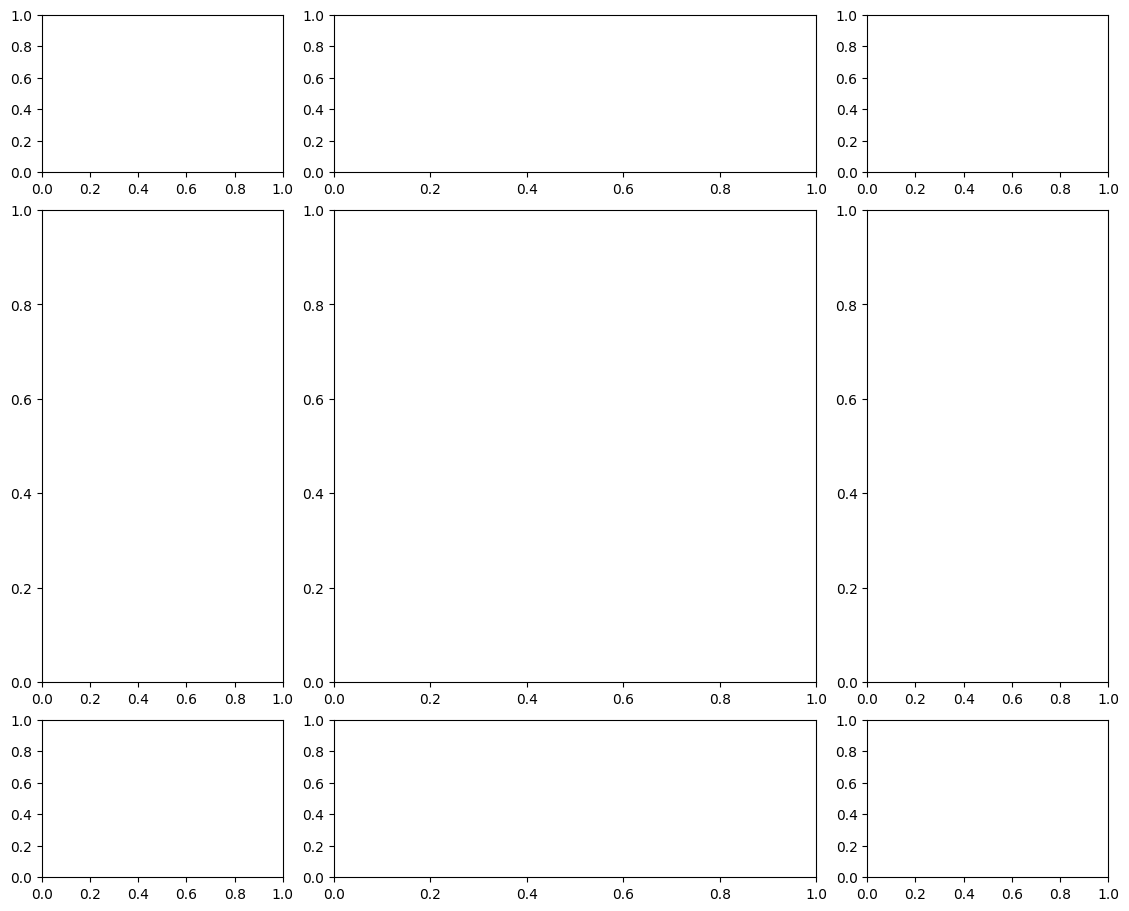

In [153]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# escudo local
ax1 = fig.add_subplot(gs[0,0:1])

# escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])

ax3 = fig.add_subplot(gs[0,1:3])

# equipo local
ax6 = fig.add_subplot(gs[1:4,:1])

ax10 = fig.add_subplot(gs[4:,:1])

# info partido
ax7 = fig.add_subplot(gs[1:4,1:3])

ax8 = fig.add_subplot(gs[4:,1:3])

# equipo visitante
ax9 = fig.add_subplot(gs[1:4,3:4])

ax11 = fig.add_subplot(gs[4:,3:4])



### Agregar la fuente

In [154]:
fuente1 = FontManager("https://github.com/google/fonts/blob/main/ofl/abeezee/ABeeZee-Regular.ttf?raw=true")

### Obtener informacion del partido

In [155]:
partido_sofascore = sofascore.get_match_data(URL_MATCH)
estadisticas_partido = sofascore.get_general_match_stats(URL_MATCH)
df_local, df_visit = sofascore.get_players_match_stats(URL_MATCH)



### Obtener jugadores destacados

In [156]:
jugador_destacado_local = df_local[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
jugador_destacado_visit = df_visit[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']

### Obtener imagen del jugador destacado de cada equipo

In [157]:

id_jug_local = df_local[df_local['name'] == jugador_destacado_local].id.values[0]
id_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].id.values[0]

try:
  imagen_jug_local = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_local}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_local = ''

try:
  imagen_jug_visit = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_visit}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_visit = ''


### Obtener mapa de calor de los jugadores destacados

In [158]:
name_jug_local = df_local[df_local['name'] == jugador_destacado_local].name.values[0]
name_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].name.values[0]

heatmap_jug_local = sofascore.get_player_heatmap(URL_MATCH, name_jug_local)
heatmap_jug_visit = sofascore.get_player_heatmap(URL_MATCH, name_jug_visit)

### Sacar inforamcion de cada jugador

In [159]:
df_jug_local = df_local[df_local['name'] == jugador_destacado_local]
df_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit]


### obtener informacion de los equipos

In [160]:
# id equipos
idlocal = partido_sofascore['homeTeam']['id']
idvisit = partido_sofascore['awayTeam']['id']

# escudos de los equipos
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

# goles de los equipos
goleslocal = partido_sofascore['homeScore']['normaltime']
golesvisit = partido_sofascore['awayScore']['normaltime']


### Obtener match momentum del partido

In [161]:
try:
    match_momentum = sofascore.match_momentum(URL_MATCH)

    match_momentum_local = match_momentum[match_momentum['value'] > 0]
    match_momentum_visit = match_momentum[match_momentum['value'] < 0]
except KeyError:
    match_momentum = None
    


### Obtener info de la jornada

In [162]:
torneo = partido_sofascore['season']['name']
fecha = partido_sofascore['roundInfo']['round']

nombre_local = partido_sofascore['homeTeam']['shortName']
nombre_visit = partido_sofascore['awayTeam']['shortName']

# si alguno de los colores del colar pasas el umbral de blanco (200 en rgb) busca el color secundario
color_local = partido_sofascore['homeTeam']['teamColors']['primary']
color_local = partido_sofascore['homeTeam']['teamColors']['secondary'] if all(int(color_local[i:i+2], 16) > 200 for i in (1, 3, 5)) else color_local

color_visit = partido_sofascore['awayTeam']['teamColors']['primary']
color_visit = partido_sofascore['awayTeam']['teamColors']['secondary'] if all(int(color_visit[i:i+2], 16) > 200 for i in (1, 3, 5)) else color_visit


f'{nombre_local} teamColor: {color_local} - {nombre_visit} teamColor: {color_visit}'


'Cobreloa teamColor: #ff3300 - Huachipato teamColor: #000066'

### Quitar las lineas de los plots

In [163]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Obtener estadísticas de cada equipo por separado

In [164]:
listas_estadisticas_partido = ['Expected goals', 'Ball possession', 'Total shots', 'Shots on target', 'Corner kicks', 'Fouls', 'Yellow cards', 'Red cards', 'Counter attacks', 'Goalkeeper saves']
# si no tiene xG lo quita
listas_estadisticas_partido = [elemento for elemento in listas_estadisticas_partido if elemento != 'Expected goals' or 'Expected goals' in estadisticas_partido['name'].to_list()]
lista_valores_partido_local = []
lista_valores_partido_visit = []

# equipo local
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['home'].values[0]
        lista_valores_partido_local.append(valor)
    else:
        lista_valores_partido_local.append(0)
    
for estadistica in listas_estadisticas_partido:
    if estadistica in estadisticas_partido['name'].values:
        valor = estadisticas_partido[estadisticas_partido['name'] == estadistica]['away'].values[0]
        lista_valores_partido_visit.append(valor)
    else:
        lista_valores_partido_visit.append(0) 

### Agregar la informacion al plot

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27764\2674590625.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_jug_local = df_jug_local.fillna(0)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27764\2674590625.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15, color=color_local)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27764\2674590625.py:36: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ax6.text(0.1,.7, f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])

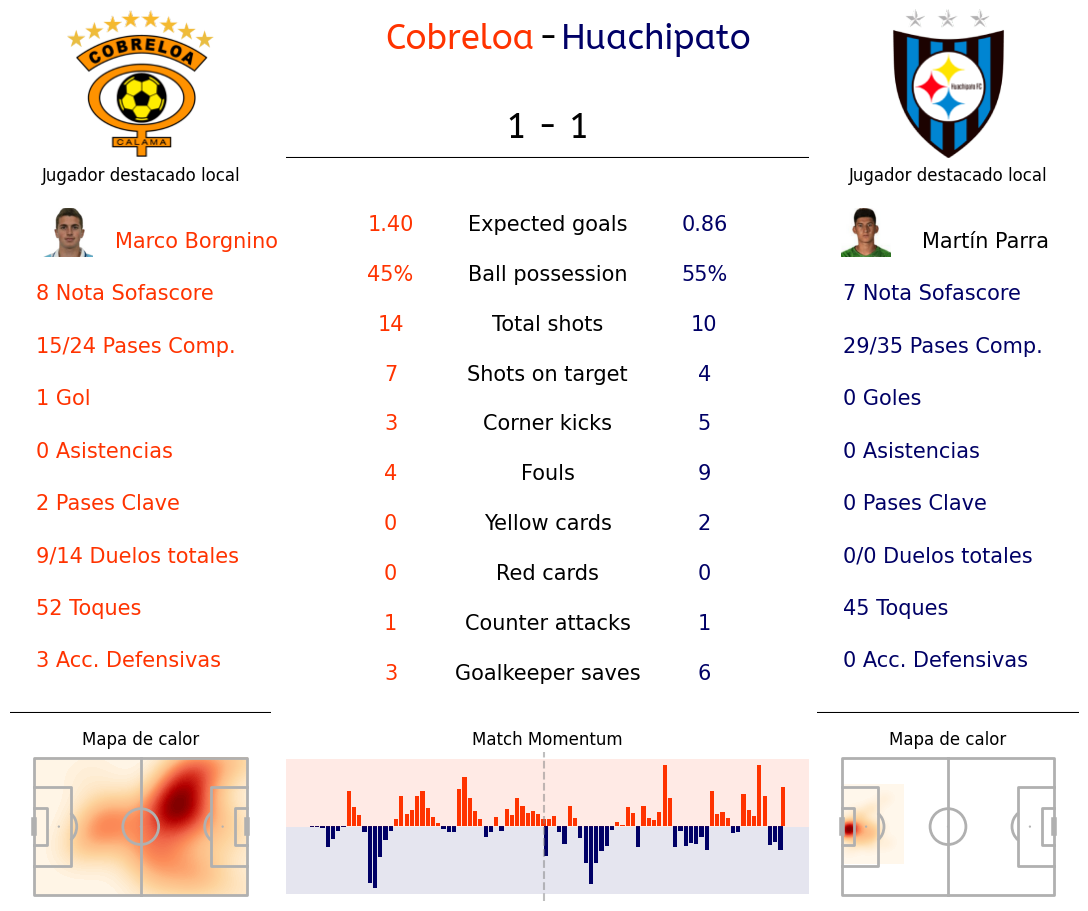

In [165]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)

# Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)

# info del partido
ax3 = fig.add_subplot(gs[0, 1:3])
ax3.text(.475, .8, f'{nombre_local}', ha='right', va='center', fontproperties=fuente1.prop, size=25, color=color_local)
ax3.text(.525, .8, f'{nombre_visit}', ha='left', va='center', fontproperties=fuente1.prop, size=25, color=color_visit)
ax3.text(.5, .8, f'-', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.5, .2, f'{goleslocal} - {golesvisit}', ha='center', va='center', fontproperties=fuente1.prop, size=25)
ax3.axhline(0, color='black')
sacar_spines(ax3)

# pasar los valores nulos a 0
df_jug_local = df_jug_local.fillna(0)
df_jug_visit = df_jug_visit.fillna(0)

# Jugador Destacado local
ax6 = fig.add_subplot(gs[1:4, :1])
ax6.set_title('Jugador destacado local')
ax_image2 = add_image(imagen_jug_local, fig, left=0.0113, bottom=0.72, width=0.055, height=0.055) if imagen_jug_local else None
ax6.text(.4,.90, f'{jugador_destacado_local}', ha='left', va='center', size=15, color=color_local)
#
ax6.text(0.1,.8, f'{int(df_jug_local["rating"])} Nota Sofascore', ha='left', va='center', size=15, color=color_local)
#
ax6.text(0.1,.7, f'{int(df_jug_local["accuratePass"])}/{int(df_jug_local["totalPass"])} Pases Comp.', ha='left', va='center', size=15, color=color_local)
#
goals = df_jug_local["goals"] if 'goals' in df_jug_local.columns else 0
ax6.text(0.1, .6, f'{int(goals)} {"Gol" if int(goals) == 1 else "Goles"}', ha='left', va='center', size=15, color=color_local)
#
goalsAssist = df_jug_local["goalsAssist"] if 'goalsAssist' in df_jug_local.columns else 0
ax6.text(0.1,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15, color=color_local)
#
keyPass = df_jug_local["keyPass"] if 'keyPass' in  df_jug_local.columns else 0
ax6.text(0.1,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15, color=color_local)
#
ax6.text(0.1,.3, f'{int(df_jug_local["duelWon"])}/{int(df_jug_local["duelLost"])+int(df_jug_local["duelWon"])} Duelos totales', ha='left', va='center', size=15, color=color_local)  
#
ax6.text(0.1, .2, f'{int(df_jug_local["touches"])} Toques', ha='left', va='center', size=15, color=color_local) 
#
ax6.text(0.1, .1, f'{int(df_jug_local["totalTackle"]+df_jug_local["interceptionWon"]+df_jug_local["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15, color=color_local) 
ax6.axhline(0, color='black')
sacar_spines(ax6)

ax10 = fig.add_subplot(gs[4:, :1])
ax10.set_title('Mapa de calor')
cmap = 'hot'
pitch = Pitch(pitch_type='opta')
pitch.draw(ax=ax10)
pitch.kdeplot(heatmap_jug_local.x, heatmap_jug_local.y, ax=ax10,
              levels=100,
              shade=True,
              zorder=-1,
              shade_lowest=True,
              cmap='OrRd')

plt.gca().invert_xaxis
sacar_spines(ax10)

# estadisticas del partido
ax7 = fig.add_subplot(gs[1:, 1:3])
i = 1.05
for n in range(len(listas_estadisticas_partido)):
    ax7.text(.5, i-.1, listas_estadisticas_partido[n], ha='center', va='center', size=15)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_local)):
    ax7.text(.2, i-.1, lista_valores_partido_local[n], ha='center', va='center', size=15, color = color_local)
    i-=.07
i = 1.05
for n in range(len(lista_valores_partido_visit)):
    ax7.text(.8, i-.1, lista_valores_partido_visit[n], ha='center', va='center', size=15, color = color_visit)
    i-=.07
sacar_spines(ax7)

# match momentum
if match_momentum is not None and not match_momentum_local.empty and not match_momentum_visit.empty:
    ax11 = fig.add_subplot(gs[4:,1:3])
    ax11.set_title('Match Momentum')
    ax11.bar(match_momentum_local.minute, match_momentum_local.value, color=color_local)
    ax11.bar(match_momentum_visit.minute, match_momentum_visit.value, color=color_visit)
    # Obtener el límite inferior y superior del eje y
    y_bottom, y_top = ax11.get_ylim()
    # Calcular la mitad del rango vertical
    y_mid = 0.5 * (y_bottom + y_top)
    # Agregar regiones de color a la mitad superior e inferior del eje y
    ax11.axhspan(y_mid, y_top, facecolor=color_local, alpha=0.1)  # Color para la mitad superior
    ax11.axhspan(y_bottom, y_mid, facecolor=color_visit, alpha=0.1)  # Color para la mitad inferior
    ax11.axvline(x=45, color='gray', linestyle='--', alpha=0.5) # linea medio tiempo
    if match_momentum_local.minute.iloc[-1] > 105:
        ax11.axvline(x=90, color='gray', linestyle='--', alpha=0.5) # linea 90 minutos
        ax11.axvline(x=105, color='gray', linestyle='--', alpha=0.5) # linea de mitad de prorroga
    sacar_spines(ax11)


# Jugador Destacado visitante
ax8 = fig.add_subplot(gs[1:4, 3:4])
ax8.set_title('Jugador destacado local')
ax_image3 = add_image(imagen_jug_visit, fig, left=0.51, bottom=0.72, width=0.055, height=0.055) if imagen_jug_visit else None
ax8.text(.4,.90, f'{jugador_destacado_visit}', ha='left', va='center', size=15)
#
ax8.text(0.1,.8, f'{int(df_jug_visit["rating"])} Nota Sofascore', ha='left', va='center', size=15, color=color_visit)
#
ax8.text(0.1,.7, f'{int(df_jug_visit["accuratePass"])}/{int(df_jug_visit["totalPass"])} Pases Comp.', ha='left', va='center', size=15, color=color_visit)
#
ax8.text(0.1, .6, f'{int(df_jug_visit["goals"])} {"Gol" if int(df_jug_visit["goals"]) == 1 else "Goles"}', ha='left', va='center', size=15, color=color_visit)
#
goalsAssist = df_jug_visit["goalsAssist"] if 'goalsAssist' in df_jug_visit.columns else 0
ax8.text(0.1,.5, f'{int(goalsAssist)} {"Asistencia" if int(goalsAssist) == 1 else "Asistencias"}', ha='left', va='center', size=15, color=color_visit)
#
keyPass = df_jug_visit["keyPass"] if 'keyPass' in  df_jug_visit.columns else 0
ax8.text(0.1,.4, f'{int(keyPass)} {"Pase Clave" if int(keyPass == 1) else "Pases Clave"}', ha='left', va='center', size=15, color=color_visit)
#
ax8.text(0.1,.3, f'{int(df_jug_visit["duelWon"])}/{int(df_jug_visit["duelLost"])+int(df_jug_visit["duelWon"])} Duelos totales', ha='left', va='center', size=15, color=color_visit)  
#
ax8.text(0.1, .2, f'{int(df_jug_visit["touches"])} Toques', ha='left', va='center', size=15, color=color_visit) 
#
ax8.text(0.1, .1, f'{int(df_jug_visit["totalTackle"]+df_jug_visit["interceptionWon"]+df_jug_visit["totalClearance"])} Acc. Defensivas', ha='left', va='center', size=15, color=color_visit) 

ax8.axhline(0, color='black')
sacar_spines(ax8)

ax9 = fig.add_subplot(gs[4:, 3:4])
ax9.set_title('Mapa de calor')
cmap = 'hot'
pitch = Pitch(pitch_type='opta')
pitch.draw(ax=ax9)
pitch.kdeplot(heatmap_jug_visit.x, heatmap_jug_visit.y, ax=ax9,
              levels=100,
              shade=True,
              zorder=-1,
              shade_lowest=True,
              cmap='OrRd')

plt.gca().invert_xaxis
sacar_spines(ax9)

